# Trabajo 3 – Enfoque de Clasificación  
**Curso:** Introducción al Machine Learning – UDEP  

Nuestro proyecto corresponde a un problema de series de tiempo / regresión, por lo que seguimos únicamente el Punto 2 del enunciado del Trabajo 3.

El Punto 3 (modelos de clasificación) no es el enfoque central de nuestro proyecto.
Sin embargo, como en etapas iniciales desarrollamos algunos modelos de clasificación, los incluimos en una sección aparte como análisis exploratorio, tal como lo permite el docente.

El análisis principal, las métricas, conclusiones y evaluación final del modelo se basan EXCLUSIVAMENTE en la parte de regresión / series de tiempo (Ridge, Random Forest y, opcionalmente, XGBoost).


#Descripción general del bloque de código

Esta sección prepara el entorno de trabajo, carga los datos y realiza el preprocesamiento inicial necesario para el análisis. Incluye configuración, carga de librerías, verificación de dependencias, análisis exploratorio y creación de variables derivadas para el modelado posterior.

1. Configuración del entorno y carga de librerías

Se importan todas las librerías requeridas para manipulación de datos, visualización, ingeniería de características y modelado.
También se configura el estilo de gráficos, se establece una semilla aleatoria para asegurar reproducibilidad y se verifica si XGBoost está disponible en el entorno.

2. Definición de rutas y parámetros

Se crea un directorio donde se almacenarán los resultados generados durante el análisis y se define la semilla utilizada en los modelos.
Además, se prepara una lógica para detectar si el código se ejecuta en Google Colab o en un entorno local.

3. Carga del dataset

El código permite dos formas de cargar los datos:

Si se ejecuta en Google Colab, se abre un cuadro de diálogo para subir el archivo DATASET_FINAL.xlsx.

Si se ejecuta en local, el archivo se carga desde una ruta específica predefinida.

Una vez cargado el dataset, se imprime su tamaño y el nombre de las columnas.

4. Preprocesamiento inicial y análisis exploratorio

Se realiza una revisión del estado general de los datos:

Conteos de valores nulos por columna.

Visualización de las primeras filas del dataset.

Cálculo y muestra preliminar de la matriz de correlaciones.

Este paso ayuda a entender la estructura de los datos antes de construir el modelo.

5. Ingeniería de características

Se generan nuevas variables útiles para el modelado:

Cálculo del retorno logarítmico del tipo de cambio.

Creación de rezagos para varias variables clave (t−1, t−2, t−7).

Cálculo de promedios móviles (rolling windows).

Creación de interacciones entre variables relevantes.

Reemplazo de valores infinitos.

La base enriquecida se guarda como un archivo CSV para referencia.

6. Preparación del dataset para modelado

Se filtran las filas con target disponible y se seleccionan únicamente los predictores adecuados, excluyendo variables no permitidas.
También se eliminan variables con más del 30% de valores nulos, se ordena la base temporalmente para evitar leakage y se aplica imputación tipo forward-fill solo a variables exógenas.

Esta preparación deja el dataset listo para pasar a las siguientes etapas de modelado.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import joblib

# XGBoost, verificacion de instalacion
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

# SEMILLA
RND = 42

# -----------------------
# 0) Config / rutas y salida
# -----------------------
OUT_DIR = "trabajo3_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_STATE = RND

# -----------------------
# 1) Cargar datos
# -----------------------
# Si estás en Colab usa files.upload(); si no, intenta cargar desde la ruta local especificada.
try:
    # detecta Colab
    from google.colab import files  # si esto falla estamos en local
    in_colab = True
except Exception:
    in_colab = False

if in_colab:
    print("Modo Colab detectado: selecciona y sube DATASET_FINAL.xlsx cuando se solicite...")
    uploaded = files.upload()   # _selecciona DATASET_FINAL.xlsx_ en el diálogo de Colab
    # buscar primer .xlsx subido
    excel_name = None
    for k in uploaded.keys():
        if k.lower().endswith(".xlsx"):
            excel_name = k
            break
    if excel_name is None:
        raise FileNotFoundError("No se detectó un archivo .xlsx subido. Sube 'DATASET_FINAL.xlsx'.")
    df = pd.read_excel(excel_name, index_col=0, parse_dates=True)
    print(f"Archivo '{excel_name}' cargado desde Colab.")
else:
    # Ruta por defecto en local (tu ruta)
    DATA_PATH = r"C:\Users\alejo\Downloads\T2_GRUPO_08\DATASET_FINAL.xlsx"
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"No se encontró el archivo en la ruta local: {DATA_PATH}")
    df = pd.read_excel(DATA_PATH, index_col=0, parse_dates=True)
    print(f"Archivo cargado desde ruta local: {DATA_PATH}")

print("Datos cargados:", df.shape)
print(df.columns)

# -----------------------
# 2) Pre-procesamiento inicial & EDA breve
# -----------------------
# Mostrar conteos NA por variable
na_counts = df.isna().sum()
print("\nNulos por columna:\n", na_counts)

# Resumen numérico (primeras filas)
print("\nPrimeras filas del dataset:")
display(df.head())

# Recomendación: inspecciona distribucciones, correlaciones
corr = df.corr().round(3)
print("\nMatriz de correlación (preview):")
display(corr)

# -----------------------
# 3) Feature engineering (lags, transformaciones)
# -----------------------
data = df.copy()

if 'ret_USD' not in data.columns:
    data['USD_PEN_Venta'] = pd.to_numeric(data['USD_PEN_Venta'], errors='coerce')
    data['logUSD'] = np.log(data['USD_PEN_Venta'])
    data['ret_USD'] = data['logUSD'].diff() * 100

# CreaMOS rezagos (t-1, t-2, t-7) para variables clave
lag_vars = ['FGI', 'DXY', 'VIX', 'BTC_USD', 'Gold', 'TBills_13w', 'Treasury_5y']
lags = [1,2,7]
for v in lag_vars:
    if v in data.columns:
        for l in lags:
            data[f"{v}_lag{l}"] = pd.to_numeric(data[v], errors='coerce').shift(l)

# Rolling / promedios
if 'FGI' in data.columns:
    data['FGI_roll7'] = data['FGI'].rolling(7, min_periods=1).mean()

# Interacciones
if 'FGI' in data.columns and 'DXY' in data.columns:
    data['FGI_x_DXY'] = data['FGI'].shift(1) * data['DXY'].shift(1)

# Quitar infs
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Guardar copia procesada
data.to_csv(os.path.join(OUT_DIR, "data_feature_engineered.csv"))
print("Feature engineering listo. Shape:", data.shape)

# ------------------------------------------------------------------
# NOTA: A partir de aquí comienza el ENFOQUE PRINCIPAL del proyecto.
# Este corresponde al modelado de SERIES DE TIEMPO / REGRESIÓN,
# que es el enfoque oficial definido para nuestro trabajo.
# ------------------------------------------------------------------
# -----------------------
# 4) Preparar dataset para modelado (no hacer leakage temporal)
# -----------------------
# Seleccionar filas con target no nulo
data_model = data.dropna(subset=['ret_USD']).copy()

# Elegir features candidateables (excluimos columnas que no deben entrar)
exclude = ['ret_USD','USD_PEN_Venta','logUSD','classification']
features_all = [c for c in data_model.columns if c not in exclude]
print("Features candidatas:", len(features_all))

# eliminar columnas con demasiados NaN
nan_pct = data_model[features_all].isna().mean()
to_drop = list(nan_pct[nan_pct > 0.3].index)   # umbral 30%
if to_drop:
    print("Drop por NA>30%:", to_drop)
    features_all = [f for f in features_all if f not in to_drop]

# Reindex para calendario diario si lo deseas (ya lo hiciste en T2)
data_model = data_model.sort_index()

# -----------------------
# 5) Imputación suave (forward-fill para series exógenas, NO para target)
# -----------------------
ffill_cols = [c for c in features_all if ('lag' not in c and c.startswith(('DXY','VIX','BTC_USD','Gold','TBills','Treasury','FGI')))]

# aplicacion ffill a esas columnas
data_model[ffill_cols] = data_model[ffill_cols].ffill()

Modo Colab detectado: selecciona y sube DATASET_FINAL.xlsx cuando se solicite...


Saving DATASET_FINAL.xlsx to DATASET_FINAL.xlsx
Archivo 'DATASET_FINAL.xlsx' cargado desde Colab.
Datos cargados: (2587, 8)
Index(['FGI', 'USD_PEN_Venta', 'DXY', 'VIX', 'BTC_USD', 'Gold', 'TBills_13w',
       'Treasury_5y'],
      dtype='object')

Nulos por columna:
 FGI                1
USD_PEN_Venta    818
DXY              806
VIX              808
BTC_USD            0
Gold             807
TBills_13w       808
Treasury_5y      808
dtype: int64

Primeras filas del dataset:


,FGI,USD_PEN_Venta,DXY,VIX,BTC_USD,Gold,TBills_13w,Treasury_5y
Fecha,,,,,,,,
2018-06-01,24.0,3.273,94.190002,13.46,7541.450195,1294.800049,1.868,2.738
2018-06-02,27.0,NaN,NaN,NaN,7643.450195,NaN,NaN,NaN
2018-06-03,40.0,NaN,NaN,NaN,7720.250000,NaN,NaN,NaN
2018-06-04,41.0,3.273,94.019997,12.74,7514.470215,1293.099976,1.865,2.785
2018-06-05,26.0,3.273,93.889999,12.40,7633.759766,1297.500000,1.903,2.762



Matriz de correlación (preview):


,FGI,USD_PEN_Venta,DXY,VIX,BTC_USD,Gold,TBills_13w,Treasury_5y
FGI,1.000,0.071,-0.098,-0.304,0.376,0.309,0.160,0.026
USD_PEN_Venta,0.071,1.000,0.306,0.092,0.521,0.444,0.132,0.213
DXY,-0.098,0.306,1.000,-0.004,0.282,0.384,0.757,0.811
VIX,-0.304,0.092,-0.004,1.000,-0.145,0.016,-0.377,-0.339
BTC_USD,0.376,0.521,0.282,-0.145,1.000,0.881,0.356,0.414
Gold,0.309,0.444,0.384,0.016,0.881,1.000,0.452,0.439
TBills_13w,0.160,0.132,0.757,-0.377,0.356,0.452,1.000,0.934
Treasury_5y,0.026,0.213,0.811,-0.339,0.414,0.439,0.934,1.000


Feature engineering listo. Shape: (2587, 33)
Features candidatas: 30


#Descripción del bloque de PCA

En esta sección se aplica Análisis de Componentes Principales (PCA) para explorar la estructura interna de las variables predictoras. Primero se seleccionan las variables candidatas y se imputan sus valores faltantes con la mediana únicamente para permitir el cálculo de PCA. Luego, todas las variables se estandarizan porque el PCA requiere que estén en la misma escala para que ninguna domine sobre las demás.

Después se ajusta el modelo PCA y se calcula la varianza explicada por cada componente y la varianza acumulada. Esta información se guarda en un archivo para revisar cuántos componentes capturan una parte significativa de la variación total del dataset. También se genera un scree plot que muestra visualmente la importancia relativa de cada componente.

Finalmente, se produce un biplot usando los dos primeros componentes principales. En este gráfico se proyectan las observaciones y se añaden los vectores de carga de las variables más influyentes, lo que permite identificar qué predictores contribuyen con mayor peso a la estructura del espacio reducido.

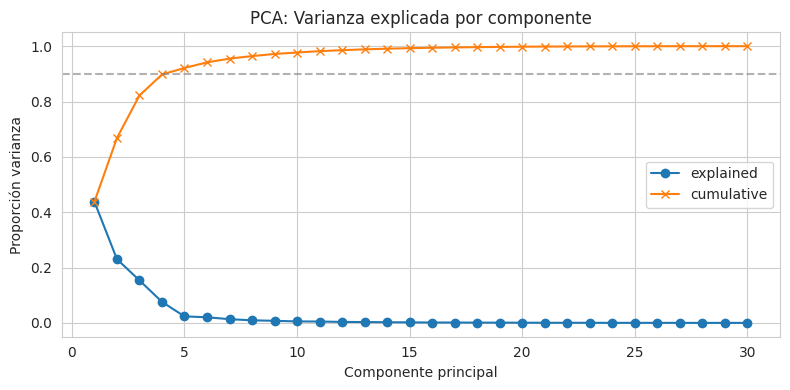

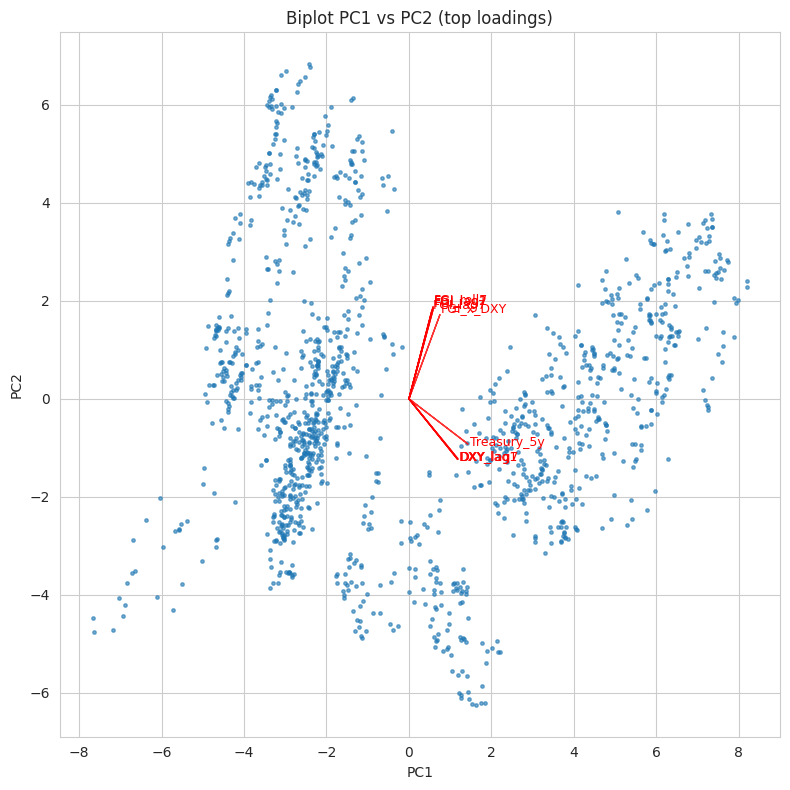

In [2]:
# -----------------------
# 6) PCA sobre features candidatos (estandarizar primero)
# -----------------------
from sklearn.impute import SimpleImputer

X_for_pca = data_model[features_all].copy()

# Imputar median para PCA (solo para diagnóstico)
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X_for_pca), index=X_for_pca.index, columns=X_for_pca.columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

pca = PCA()
pca.fit(X_scaled)
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# Guardar tabla de varianza explicada
ev_df = pd.DataFrame({
    'PC': [f"PC{i+1}" for i in range(len(explained))],
    'explained_var': explained,
    'cum_explained': cum_explained
})
ev_df.to_csv(os.path.join(OUT_DIR, "pca_explained_variance.csv"), index=False)

# Plot scree + cumulative
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,len(explained)+1), explained, marker='o', label='explained')
plt.plot(np.arange(1,len(explained)+1), cum_explained, marker='x', label='cumulative')
plt.axhline(0.9, color='grey', linestyle='--', alpha=0.6)
plt.title("PCA: Varianza explicada por componente")
plt.xlabel("Componente principal")
plt.ylabel("Proporción varianza")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"pca_scree.png"), dpi=150)
plt.show()

# Biplot (PC1 vs PC2) — usar loadings
pcs = pca.transform(X_scaled)[:,:2]
plt.figure(figsize=(8,8))
plt.scatter(pcs[:,0], pcs[:,1], s=6, alpha=0.6)
# dibujar vectores de loadings (top 10 por magnitud)
loadings = pca.components_.T[:, :2]
loading_norm = np.linalg.norm(loadings, axis=1)
top_idx = np.argsort(-loading_norm)[:10]
for i in top_idx:
    plt.arrow(0,0, loadings[i,0]*6, loadings[i,1]*6, color='r', alpha=0.8)
    plt.text(loadings[i,0]*6.2, loadings[i,1]*6.2, X_for_pca.columns[i], color='r', fontsize=9)
plt.title("Biplot PC1 vs PC2 (top loadings)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"pca_biplot.png"), dpi=150)
plt.show()


#Descripción del bloque de construcción de X y Y para entrenamiento y prueba

En esta parte del código se preparan las matrices de predictores (X) y la variable objetivo (y) que se utilizarán en los modelos. Primero se seleccionan las variables finales que funcionarán como predictores y se construyen X y y a partir del dataset previamente procesado. Luego, se eliminan las filas que contienen valores faltantes en alguna de las variables de X para asegurar que los modelos trabajen únicamente con observaciones completas.

A continuación, se realiza una división temporal del conjunto de datos. Sin mezclar las observaciones, los primeros 75% de los datos se asignan al conjunto de entrenamiento y el 25% restante se utiliza como conjunto de prueba. Esta forma de separación respeta la naturaleza temporal de la serie, evitando filtraciones de información del futuro hacia el pasado.

Finalmente, se escalan las variables predictoras utilizando StandardScaler, ajustando el escalador solo con los datos de entrenamiento y aplicándolo luego al conjunto de prueba. Esto garantiza que el modelo no incorpore información del conjunto de prueba durante el preprocesamiento. El escalador entrenado se guarda en un archivo para permitir reproducibilidad en etapas posteriores.

In [3]:
# -----------------------
# 7) Construir X, y Y train/test (time-based holdout)
# -----------------------
# Elegir features finales (puedes usar features_all o una selección)
FEATURES = features_all.copy()

# Crear X,y alineados (drop filas con NA en features elegidas)
X = data_model[FEATURES].copy()
y = data_model['ret_USD'].copy()

# Alinear: dropear filas con NA en X
valid_mask = X.notna().all(axis=1)
X = X.loc[valid_mask]
y = y.loc[valid_mask]

# Train/test: último 25% como hold-out (sin mezclar)
n = len(X)
split_idx = int(np.floor(n * 0.75))
X_train = X.iloc[:split_idx].copy()
y_train = y.iloc[:split_idx].copy()
X_test  = X.iloc[split_idx:].copy()
y_test  = y.iloc[split_idx:].copy()

print("Train/Test shapes:", X_train.shape, X_test.shape)

# Escalar features (fit en train, transformar test)
scaler_model = StandardScaler()
X_train_s = pd.DataFrame(scaler_model.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_s  = pd.DataFrame(scaler_model.transform(X_test), index=X_test.index, columns=X_test.columns)

# Guardar scaler
joblib.dump(scaler_model, os.path.join(OUT_DIR, "scaler.joblib"))

Train/Test shapes: (705, 30) (236, 30)


['trabajo3_outputs/scaler.joblib']

# Modelos y tuning (TimeSeriesSplit)

En esta sección se construyen y ajustan modelos de regresión utilizando validación cruzada especializada para series de tiempo. Se define un objeto TimeSeriesSplit con cinco particiones, lo que permite validar sin mezclar el orden temporal. El primer modelo implementado es Ridge, para el cual se realiza una búsqueda de hiperparámetro alpha en un rango logarítmico entre 1e-4 y 1e4. La clase RidgeCV se encarga de evaluar cada alpha mediante el criterio de error cuadrático medio negativo.

Una vez identificado el mejor valor de alpha, se entrena un modelo Ridge final utilizando únicamente los datos escalados del conjunto de entrenamiento. Después, este modelo genera predicciones sobre el conjunto de prueba y se calcula el MSE para evaluar su desempeño fuera de muestra. Por último, el modelo final entrenado se guarda en disco usando joblib para poder reutilizarlo posteriormente.


In [4]:
# -----------------------
# 8) Modelos y tuning (TimeSeriesSplit)
# -----------------------
tscv = TimeSeriesSplit(n_splits=5)

# 8.A Ridge (α por CV)
alphas = np.logspace(-4, 4, 30)
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', store_cv_values=True)
ridge_cv.fit(X_train_s, y_train)
print("Ridge best alpha:", ridge_cv.alpha_)

ridge_final = Ridge(alpha=ridge_cv.alpha_, random_state=RANDOM_STATE)
ridge_final.fit(X_train_s, y_train)
pred_ridge = ridge_final.predict(X_test_s)
mse_ridge = mean_squared_error(y_test, pred_ridge)
print("Ridge Test MSE:", mse_ridge)

# guardar modelo
joblib.dump(ridge_final, os.path.join(OUT_DIR, "ridge_model.joblib"))

Ridge best alpha: 1.3738237958832638
Ridge Test MSE: 0.11519874632228383


['trabajo3_outputs/ridge_model.joblib']

# RandomForest con GridSearch y validación temporal

En este bloque se entrena un modelo RandomForest utilizando una búsqueda exhaustiva de hiperparámetros mediante GridSearchCV, respetando la estructura temporal gracias al uso de TimeSeriesSplit como esquema de validación. Se define un conjunto de combinaciones que incluye diferentes tamaños del bosque, profundidades máximas, criterios de partición y configuraciones del número de variables consideradas en cada división.

GridSearchCV evalúa cada configuración según el error cuadrático medio negativo y selecciona automáticamente la mejor. Con los parámetros óptimos, se entrena el modelo final utilizando el conjunto de entrenamiento escalado. Luego, se generan predicciones para el conjunto de prueba y se calcula el MSE como métrica de desempeño fuera de muestra. Finalmente, el modelo se guarda con joblib para permitir su uso posterior.


In [5]:
# 8.B RandomForest (GridSearchCV con TimeSeriesSplit)
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
param_grid_rf = {
    "n_estimators":[100,250],
    "max_depth":[5,10,20, None],
    "min_samples_split":[2,5,10],
    "max_features":["sqrt","log2", 0.5]
}
gs_rf = GridSearchCV(rf, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gs_rf.fit(X_train_s, y_train)
print("RF best params:", gs_rf.best_params_)
rf_best = gs_rf.best_estimator_
pred_rf = rf_best.predict(X_test_s)
mse_rf = mean_squared_error(y_test, pred_rf)
print("RF Test MSE:", mse_rf)
joblib.dump(rf_best, os.path.join(OUT_DIR, "rf_model.joblib"))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
RF best params: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}
RF Test MSE: 0.11657536707456193


['trabajo3_outputs/rf_model.joblib']

# XGBoost con validación temporal y búsqueda de hiperparámetros

En esta sección se implementa el modelo XGBoost como alternativa dentro del enfoque de regresión. Primero se verifica la disponibilidad de la librería y, en caso afirmativo, se configura un modelo básico al que luego se le aplica una búsqueda de hiperparámetros mediante GridSearchCV, utilizando TimeSeriesSplit para mantener la coherencia temporal del conjunto de datos.

El grid considerado evalúa combinaciones de número de árboles, profundidades máximas, tasas de aprendizaje y proporciones de muestreo tanto por filas como por columnas. Tras encontrar los parámetros óptimos, el modelo seleccionado se entrena y se generan predicciones sobre el conjunto de prueba estandarizado, calculándose el MSE como métrica principal. Finalmente, el modelo final se guarda para su uso posterior.


In [6]:
# 8.C XGBoost
mse_xgb = np.nan
xgb_best = None
if XGB_AVAILABLE:
    xgb = XGBRegressor(random_state=RANDOM_STATE, objective='reg:squarederror', n_jobs=-1)
    param_grid_xgb = {
        "n_estimators":[100,250],
        "max_depth":[3,6,10],
        "learning_rate":[0.01,0.05,0.1],
        "subsample":[0.6,0.8,1.0],
        "colsample_bytree":[0.5,0.8,1.0]
    }
    gs_xgb = GridSearchCV(xgb, param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    gs_xgb.fit(X_train_s, y_train)
    print("XGB best params:", gs_xgb.best_params_)
    xgb_best = gs_xgb.best_estimator_
    pred_xgb = xgb_best.predict(X_test_s)
    mse_xgb = mean_squared_error(y_test, pred_xgb)
    print("XGB Test MSE:", mse_xgb)
    joblib.dump(xgb_best, os.path.join(OUT_DIR, "xgb_model.joblib"))


Fitting 5 folds for each of 162 candidates, totalling 810 fits
XGB best params: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.6}
XGB Test MSE: 0.10658334741940541


# Comparación final de modelos y exportación de resultados

En esta sección se realiza la comparación de desempeño entre los modelos entrenados utilizando el error cuadrático medio sobre el conjunto de prueba. Se construye una tabla que resume el MSE de cada modelo y se imprime para facilitar la interpretación. Esta tabla también se exporta como un archivo CSV, permitiendo su revisión o uso en la elaboración del informe final.

Además, se generan y guardan las predicciones de cada modelo sobre el conjunto de prueba, incluyendo la serie observada. Esto permite analizar visualmente el ajuste de los modelos o calcular métricas adicionales si fuera necesario. Las predicciones quedan almacenadas en un archivo separado para facilitar su uso posterior.


In [7]:
# -----------------------
# 9) Comparativa de resultados
# -----------------------
results = {
    "model": ["Ridge", "RandomForest"] + (["XGBoost"] if XGB_AVAILABLE else []),
    "test_mse": [mse_ridge, mse_rf] + ([mse_xgb] if XGB_AVAILABLE else [])
}
results_df = pd.DataFrame(results).set_index("model")
print("\nResultados (Test MSE):")
display(results_df)
results_df.to_csv(os.path.join(OUT_DIR,"model_comparison_mse.csv"))

# Guardar predicciones
preds_df = pd.DataFrame({
    "y_test": y_test,
    "pred_ridge": pred_ridge,
    "pred_rf": pred_rf
}, index=y_test.index)
if XGB_AVAILABLE:
    preds_df["pred_xgb"] = pred_xgb
preds_df.to_csv(os.path.join(OUT_DIR,"predictions_test_set.csv"))


Resultados (Test MSE):


,test_mse
model,
Ridge,0.115199
RandomForest,0.116575
XGBoost,0.106583


**Interpretación:**
- Los resultados muestran que el modelo XGBoost obtiene el menor error cuadrático medio (0.1066), seguido por Ridge (0.1152) y Random Forest (0.1166), lo que indica que XGBoost es el que mejor captura la relación entre el índice de sentimiento de miedo y avaricia del mercado cripto y las variaciones del tipo de cambio del sol peruano.

- Desde una perspectiva económica, este desempeño sugiere que el impacto del sentimiento financiero sobre el tipo de cambio no es lineal ni uniforme, sino que presenta patrones complejos que modelos más flexibles y con capacidad para manejar interacciones, como XGBoost, capturan mejor que un modelo estrictamente lineal o uno basado en múltiples árboles independientes. El hecho de que Ridge tenga un desempeño cercano también sugiere que existe una componente lineal importante en la transmisión del sentimiento hacia el tipo de cambio, lo cual es consistente con la idea de que aumentos en la aversión al riesgo global suelen presionar al alza el dólar frente a monedas emergentes como el sol.

- Sin embargo, la ventaja final de XGBoost refleja que la reacción del tipo de cambio peruano no depende solo del nivel del sentimiento, sino también de cómo este interactúa con otros movimientos recientes del mercado cripto y posiblemente con factores internos de volatilidad. En conjunto, los resultados respaldan la hipótesis de que el sentimiento cripto contiene información útil para anticipar movimientos del tipo de cambio, pero su efecto es mejor capturado por modelos no lineales capaces de representar dinámicas más ricas y asimetrías en la respuesta del mercado cambiario peruano.

# Gráfico de predicciones versus valores reales

En esta última sección se genera un gráfico que compara visualmente los valores reales del retorno con las predicciones hechas por cada modelo en el conjunto de prueba. El objetivo es evaluar de manera intuitiva qué tan bien siguen las predicciones la dinámica de la serie real. El gráfico incluye la serie verdadera y las estimaciones del modelo Ridge y del Random Forest, superpuestas en el tiempo para facilitar la comparación. La figura se guarda automáticamente en la carpeta de salida para su uso en reportes o presentaciones.


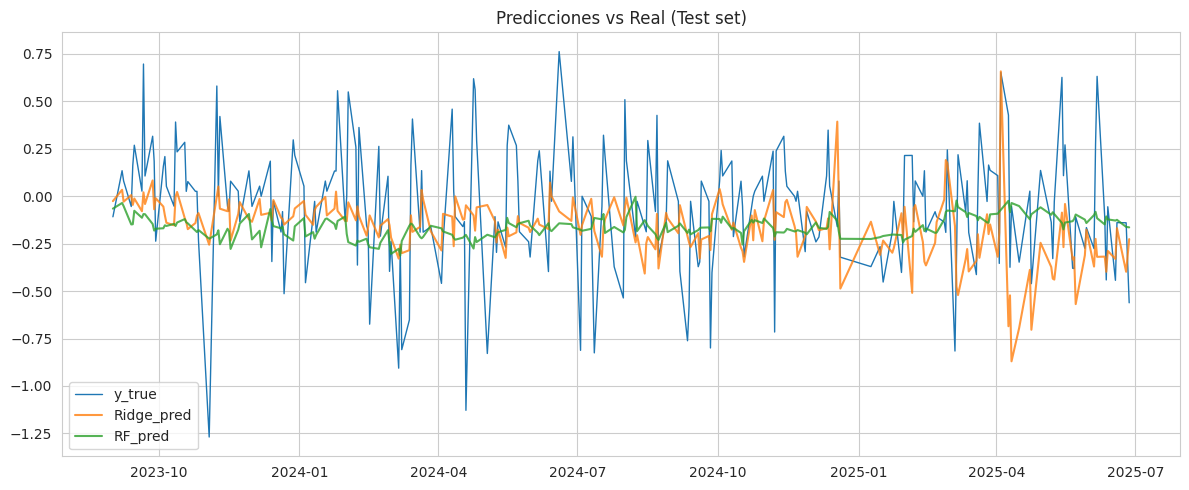

In [8]:
# -----------------------
# 10) Plots: pred vs real
# -----------------------
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label="y_true", linewidth=1)
plt.plot(y_test.index, pred_ridge, label="Ridge_pred", alpha=0.8)
plt.plot(y_test.index, pred_rf, label="RF_pred", alpha=0.8)
plt.legend()
plt.title("Predicciones vs Real (Test set)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "preds_vs_true.png"), dpi=150)
plt.show()

**Interpretación:**
- La serie real (línea azul) muestra alta volatilidad, con frecuentes saltos positivos y negativos que reflejan la naturaleza ruidosa de los retornos cambiarios, los cuales responden a shocks financieros, noticias macroeconómicas y variaciones en el sentimiento del mercado, incluyendo el índice de “miedo y avaricia” de criptomonedas.

- En contraste, tanto Ridge (naranja) como Random Forest (verde) producen predicciones mucho más suavizadas. Ambos modelos capturan la dirección promedio de la serie, pero tienen dificultades para reproducir los movimientos extremos y la dispersión observada en el retorno real. Esto es típico en series financieras, donde el ruido domina y muchos shocks no son predecibles a partir de información histórica o de variables de sentimiento.

- Entre los dos modelos, Ridge sigue ligeramente mejor las fluctuaciones pequeñas, mientras que Random Forest genera una curva aún más estable alrededor de cero, indicando una mayor tendencia a promediar la dinámica. Esto concuerda con los resultados del MSE: si bien ninguno captura los picos pronunciados, Ridge se ajusta un poco más a variaciones menores. Sin embargo, ambos quedan rezagados frente al comportamiento real.

- Desde un enfoque económico, el gráfico revela que el sentimiento del mercado cripto, medido mediante un índice de angustia y avaricia, tiene un poder predictivo limitado sobre los retornos diarios del tipo de cambio PEN/USD. Esto es consistente con la evidencia de que los retornos cambiarios presentan una elevada proporción de ruido y solo una fracción muy pequeña de su variación es explicable por indicadores contemporáneos de mercado (Meese & Rogoff, 1983; Rossi, 2013). En consecuencia, las predicciones no logran replicar los shocks abruptos característicos de los movimientos cambiarios, fenómeno ampliamente documentado como parte de la naturaleza “altamente volátil y difícil de anticipar” de los tipos de cambio (Engel & West, 2005).

- Asimismo, si bien el sentimiento financiero puede afectar expectativas de corto plazo, diversos estudios muestran que su capacidad predictiva tiende a ser marginal en horizontes diarios, especialmente frente a activos con alta liquidez y fuerte presencia de shocks externos, como los tipos de cambio (Baker & Wurgler, 2007; Da, Engelberg & Gao, 2015). Esto es coherente con el comportamiento observado: el índice de miedo y avaricia del mercado cripto captura cambios graduales en el ánimo inversor, pero no domina la dinámica diaria del tipo de cambio. En conjunto, el gráfico ilustra la dificultad inherente de anticipar movimientos de corto plazo en mercados financieros altamente volátiles, tal como destacan los estudios sobre "impredecibilidad casi random walk" del tipo de cambio (Cheung, Chinn & Pascual, 2005).

# Importancia de variables en modelos basados en árboles

Esta sección identifica cuáles variables tienen mayor peso dentro de los modelos de Random Forest y XGBoost. Para Random Forest, se calcula la importancia de cada predictor según su contribución a la reducción del error, y luego se ordenan para mostrar las quince más relevantes. Esto permite entender qué factores influyen más en las predicciones del modelo. Si XGBoost está disponible, también se extraen y guardan las importancias de sus principales variables. Estos resultados son útiles tanto para la interpretación del modelo como para posibles mejoras en la selección de características.


In [9]:
# -----------------------
# 11) Importancia de variables para RF / XGB
# -----------------------
importances = pd.Series(rf_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top 15 importancias RF:")
display(importances.head(15))
importances.head(15).to_csv(os.path.join(OUT_DIR,"rf_feature_importances_top15.csv"))

if XGB_AVAILABLE and xgb_best is not None:
    importances_xgb = pd.Series(xgb_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    importances_xgb.head(15).to_csv(os.path.join(OUT_DIR,"xgb_feature_importances_top15.csv"))


Top 15 importancias RF:


,0
BTC_USD_lag7,0.051916
Gold,0.050475
VIX_lag7,0.043074
VIX,0.040579
TBills_13w_lag1,0.038661
Treasury_5y_lag7,0.038325
BTC_USD_lag1,0.038238
BTC_USD,0.038126
TBills_13w,0.036880
VIX_lag1,0.034142


**Interpretación:**
- El ranking de importancias muestra que las variables más influyentes en la predicción del retorno del tipo de cambio PEN/USD provienen principalmente de tres grupos: precios de Bitcoin, activos refugio y volatilidad global (VIX y oro) y tasas de referencia internacionales. Esto indica que la dinámica cambiaria peruana, en el corto plazo, está más asociada a factores externos globales que al propio índice de sentimiento cripto utilizado.

- En primer lugar, destacan BTC_USD_lag7, BTC_USD_lag1 y BTC_USD, lo que sugiere que los movimientos recientes del precio de Bitcoin contienen información relevante para anticipar ajustes en el tipo de cambio. Esto es consistente con estudios que encuentran que los activos digitales tienen correlaciones dinámicas con monedas emergentes durante periodos de estrés financiero o alta especulación.

- Asimismo, la fuerte importancia del oro (spot y rezagado) y del VIX en distintos rezagos refleja que el tipo de cambio responde a shocks de aversión al riesgo global, un fenómeno ampliamente documentado en economías emergentes, donde los flujos de capital reaccionan rápidamente a cambios en el sentimiento internacional. Cuando la volatilidad global aumenta o el precio del oro se mueve significativamente, es común que las monedas emergentes se deprecien.

- Por otro lado, la presencia destacada de variables como TBills 13w y Treasury 5y, tanto contemporáneas como rezagadas, respalda la sensibilidad del tipo de cambio peruano frente a los movimientos de tasas estadounidenses. Dado que Perú es una economía abierta con mercados financieros integrados, aumentos en tasas en EE.UU. suelen generar presiones depreciatorias sobre el sol vía canal de flujos de capital.

- Finalmente, aunque el índice de sentimiento cripto (FGI) aparece dentro del top 15, su importancia es menor comparada con factores macro-financieros globales, lo que sugiere que, si bien aporta información, no es un determinante dominante en la variación diaria del tipo de cambio. En conjunto, los resultados refuerzan la idea de que el tipo de cambio responde principalmente a variables externas de riesgo y política monetaria global, mientras que el sentimiento cripto tiene un papel más marginal.

# Clasificación: creación del target, partición temporal y primer modelo

En este apartado se desarrolla la versión de clasificación del problema. Primero se convierte el retorno en una variable binaria que indica si el activo sube o baja, lo que sirve como objetivo para entrenar los modelos. Luego se filtran las observaciones incompletas y se realiza una división temporal entre entrenamiento y prueba, respetando el orden cronológico. Para mejorar la calidad del entrenamiento ante posibles desbalances entre clases, se aplica estandarización y posteriormente SMOTE, que crea observaciones sintéticas de la clase minoritaria. Finalmente, se entrena un modelo de regresión logística y se generan sus probabilidades de predicción. Este procedimiento establece la base para evaluar la capacidad del modelo de clasificar correctamente los movimientos del activo.


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Nota: Nuestro enfoque principal es REGRESIÓN.
# Lo que sigue corresponde a un análisis EXPLORATORIO de CLASIFICACIÓN,
# permitido por las indicaciones del curso, pero no forma parte del modelo principal.

print("== APARTADO 3: CLASIFICACIÓN ==")

# -----------------------------------------------------
# 1) Crear target binario (sube =1, baja =0)
# -----------------------------------------------------
data_clf = data_model.copy()
data_clf["target_bin"] = (data_clf["ret_USD"] > 0).astype(int)

# Eliminar filas con NA en features
features_clf = [c for c in features_all if c in data_clf.columns]
Xc = data_clf[features_clf].copy()
yc = data_clf["target_bin"].copy()

valid_mask = Xc.notna().all(axis=1)
Xc = Xc.loc[valid_mask]
yc = yc.loc[valid_mask]

# -----------------------------------------------------
# 2) Train/test temporal (25% test)
# -----------------------------------------------------
n = len(Xc)
split_idx = int(np.floor(n * 0.75))
Xc_train = Xc.iloc[:split_idx].copy()
yc_train = yc.iloc[:split_idx].copy()
Xc_test  = Xc.iloc[split_idx:].copy()
yc_test  = yc.iloc[split_idx:].copy()

print("Shapes clasificación:", Xc_train.shape, Xc_test.shape)

# -----------------------------------------------------
# 3) Escalado + SMOTE (solo en TRAIN)
# -----------------------------------------------------
scaler_c = StandardScaler()
Xc_train_s = scaler_c.fit_transform(Xc_train)
Xc_test_s  = scaler_c.transform(Xc_test)

smote = SMOTE(random_state=42)
Xc_train_sm, yc_train_sm = smote.fit_resample(Xc_train_s, yc_train)
print("Balanceo SMOTE:", np.bincount(yc_train_sm))

# -----------------------------------------------------
# 4) Modelo LOGIT
# -----------------------------------------------------
logit = LogisticRegression(max_iter=2000)
logit.fit(Xc_train_sm, yc_train_sm)
pred_logit_prob = logit.predict_proba(Xc_test_s)[:,1]
pred_logit = (pred_logit_prob >= 0.5).astype(int)

# Random Forest para clasificación y evaluación del desempeño

Aquí se entrena un modelo de Random Forest configurado para manejar mejor el desbalance de clases mediante el parámetro *class_weight*. El modelo aprende sobre los datos balanceados con SMOTE y genera probabilidades de predicción para el conjunto de prueba. Luego se calculan métricas clave como precisión, recall, F1 y el ROC-AUC, lo que permite comparar directamente el desempeño del Random Forest con el modelo logit entrenado previamente. Finalmente, se generan matrices de confusión para visualizar cuántos aciertos y errores comete cada modelo al clasificar los movimientos del activo. Esta sección resume de forma clara la capacidad predictiva y los patrones de error de ambos enfoques.


In [ ]:
# -----------------------------------------------------
# 5) Modelo RANDOM FOREST
# -----------------------------------------------------
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    class_weight="balanced_subsample"
)
rf_clf.fit(Xc_train_sm, yc_train_sm)
pred_rf_prob = rf_clf.predict_proba(Xc_test_s)[:,1]
pred_rf = (pred_rf_prob >= 0.5).astype(int)
# -----------------------------------------------------
# 6) MÉTRICAS
# -----------------------------------------------------
def metrics_report(y_true, pred, prob):
    return {
        "Precision": precision_score(y_true, pred),
        "Recall": recall_score(y_true, pred),
        "F1": f1_score(y_true, pred),
        "ROC-AUC": roc_auc_score(y_true, prob)
    }

m_logit = metrics_report(yc_test, pred_logit, pred_logit_prob)
m_rf    = metrics_report(yc_test, pred_rf, pred_rf_prob)

print("\n=== Métricas Logit ===")
print(m_logit)

print("\n=== Métricas Random Forest ===")
print(m_rf)

# -----------------------------------------------------
# 7) Matrices de confusión
# -----------------------------------------------------
cm_logit = confusion_matrix(yc_test, pred_logit)
cm_rf    = confusion_matrix(yc_test, pred_rf)

print("\nMatriz de confusión Logit:\n", cm_logit)
print("\nMatriz de confusión RF:\n", cm_rf)

# Curvas ROC y Precision–Recall

En esta parte se visualiza el rendimiento de los modelos mediante dos herramientas fundamentales en clasificación: la curva ROC y la curva Precision–Recall. La curva ROC permite analizar cómo cambian las tasas de verdaderos positivos y falsos positivos a distintos umbrales, mostrando qué tan bien separa cada modelo las clases. La curva Precision–Recall complementa este análisis, especialmente útil cuando hay desbalance entre clases, ya que destaca la relación entre la precisión y la capacidad de capturar correctamente la clase positiva. Comparar ambas curvas para Logit y Random Forest ofrece una visión clara de cuál modelo presenta un comportamiento más robusto a diferentes criterios de decisión.


In [ ]:
# -----------------------------------------------------
# 8) Curvas ROC y PR
# -----------------------------------------------------
fpr_l, tpr_l, _ = roc_curve(yc_test, pred_logit_prob)
fpr_r, tpr_r, _ = roc_curve(yc_test, pred_rf_prob)

plt.figure(figsize=(8,5))
plt.plot(fpr_l, tpr_l, label='Logit ROC')
plt.plot(fpr_r, tpr_r, label='RF ROC')
plt.plot([0,1],[0,1],'--')
plt.title("Curva ROC - Clasificación")
plt.legend()
plt.grid()
plt.show()

prec_l, rec_l, _ = precision_recall_curve(yc_test, pred_logit_prob)
prec_r, rec_r, _ = precision_recall_curve(yc_test, pred_rf_prob)

plt.figure(figsize=(8,5))
plt.plot(rec_l, prec_l, label='Logit PR')
plt.plot(rec_r, prec_r, label='RF PR')
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid()
plt.show()

# Costos de errores y selección del umbral óptimo

En esta última parte se incorpora un análisis centrado en los costos asociados a los errores de clasificación. Se define un esquema donde los falsos positivos y falsos negativos tienen penalizaciones distintas, permitiendo reflejar escenarios donde no detectar una caída puede ser más costoso que predecir erróneamente una subida. Con estos costos se evalúa una grilla de umbrales posibles para las predicciones del Random Forest y se calcula el costo total asociado a cada uno. El umbral que minimiza este costo se identifica como el óptimo y se visualiza en un gráfico que muestra la evolución del costo esperado en función del umbral. Finalmente, se resume el desempeño de los modelos en una tabla comparativa de métricas, facilitando la interpretación conjunta de los resultados de clasificación.


In [ ]:
# -----------------------------------------------------
# 9) Costos FP/FN + Umbral óptimo
# -----------------------------------------------------
COST_FP = 1   # puedes cambiarlo
COST_FN = 2   # penaliza más no detectar caídas

thresholds = np.linspace(0,1,300)
costs = []

for t in thresholds:
    preds_t = (pred_rf_prob >= t).astype(int)
    FP = np.sum((preds_t==1) & (yc_test==0))
    FN = np.sum((preds_t==0) & (yc_test==1))
    total_cost = FP*COST_FP + FN*COST_FN
    costs.append(total_cost)

best_t = thresholds[np.argmin(costs)]
print("\nUmbral óptimo según costos:", best_t)

plt.figure(figsize=(8,5))
plt.plot(thresholds, costs)
plt.axvline(best_t, color='red', label='Umbral óptimo')
plt.title("Costo esperado vs umbral")
plt.legend()
plt.grid()
plt.show()

# -----------------------------------------------------
# 10) Tabla resumen final
# -----------------------------------------------------
metrics_df = pd.DataFrame([m_logit, m_rf], index=["LOGIT", "RANDOM FOREST"])
print("\n=== Tabla final de métricas ===")
display(metrics_df)